# Notebook 06 — Macro Research Dashboard (Static / Plotly v1)

Assemble transformations, regimes, and templates into a single macro research dashboard.

This notebook:
- centralizes key charts
- makes regime context visible everywhere
- prepares the ground for 06v2 and 07

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from macro_utils.transforms import zscore
from macro_utils.utils import (
    build_transformed_dataset,
    prepare_plot_df,
)
from macro_utils.regimes import build_macro_regimes, detect_transitions
from macro_utils.events import event_window

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_OUTPUTS = PROJECT_ROOT / "data" / "outputs"
DATA_OUTPUTS.mkdir(parents=True, exist_ok=True)

In [2]:
# load data

monthly = pd.read_csv(
    DATA_RAW / "fred_monthly.csv",
    index_col=0,
    parse_dates=True
)

In [3]:
# build core dataset

df = build_transformed_dataset(monthly)
df = build_macro_regimes(df)

df.head()

c:\Users\JR\OneDrive\Mini PC\FRED\macro_utils\transforms.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return series.pct_change(periods) * 100
c:\Users\JR\OneDrive\Mini PC\FRED\macro_utils\transforms.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return series.pct_change(1) * 100


,GDP_YoY,CPI_YoY,CPI_MoM,UNRATE,FEDFUNDS,Growth_Regime,Inflation_Regime,Policy_Regime,Macro_Regime
DATE,,,,,,,,,
1991-01-31,2.766649,5.647059,0.372578,6.4,6.91,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-02-28,2.766649,5.312500,0.074239,6.6,6.25,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-03-31,2.766649,4.821151,0.000000,6.8,6.12,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-04-30,2.799215,4.809930,0.222552,6.7,5.91,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1991-05-31,2.799215,5.034857,0.370096,6.9,5.78,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing


In [4]:
# plotly-compatible dataframe

plot_df = prepare_plot_df(df)
plot_df.head()

,DATE,GDP_YoY,CPI_YoY,CPI_MoM,UNRATE,FEDFUNDS,Growth_Regime,Inflation_Regime,Policy_Regime,Macro_Regime
0,1991-01-31,2.766649,5.647059,0.372578,6.4,6.91,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
1,1991-02-28,2.766649,5.312500,0.074239,6.6,6.25,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
2,1991-03-31,2.766649,4.821151,0.000000,6.8,6.12,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
3,1991-04-30,2.799215,4.809930,0.222552,6.7,5.91,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing
4,1991-05-31,2.799215,5.034857,0.370096,6.9,5.78,Expansion,Inflationary,Easing,Expansion / Inflationary / Easing


In [5]:
# regime timeline

fig = px.scatter(
    plot_df,
    x="DATE",
    y="Macro_Regime",
    color="Macro_Regime",
    title="Macro Regime Timeline",
    height=300
)

fig.update_yaxes(showticklabels=False)
fig.show()

In [6]:
# Growth, Inflation, Policy (Levels + Regimes)
 
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df["GDP_YoY"],
    name="GDP YoY",
    line=dict(width=2)
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df["CPI_YoY"],
    name="CPI YoY",
    line=dict(width=2)
))

fig.update_layout(
    title="Growth and Inflation Over Time",
    height=450
)

fig.show()


In [7]:
# Distribution by Regime (Example: Unemployment)

fig = px.box(
    df,
    x="Macro_Regime",
    y="UNRATE",
    points="outliers",
    title="Unemployment Rate by Macro Regime",
    height=450
)

fig.show()

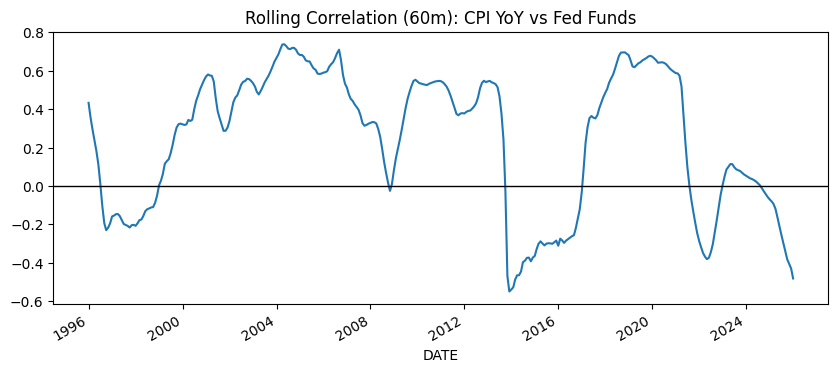

In [8]:
# Rolling Relationship (CPI vs Policy)
 
rolling_corr = (
    df["CPI_YoY"]
    .rolling(60)
    .corr(df["FEDFUNDS"])
)

rolling_corr.plot(
    figsize=(10, 4),
    title="Rolling Correlation (60m): CPI YoY vs Fed Funds"
)

plt.axhline(0, color="black", lw=1)
plt.show()

In [9]:
# event study setup (contractions)

contraction_dates = df.index[
    df["Growth_Regime"].shift(1).eq("Expansion") &
    df["Growth_Regime"].eq("Contraction")
]

In [10]:
# event study: unemployment

WINDOW = 12

windows = event_window(
    df["UNRATE"],
    contraction_dates,
    window=WINDOW
)

mean_path = windows.mean()
p10 = windows.quantile(0.10)
p90 = windows.quantile(0.90)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mean_path.index,
    y=mean_path,
    name="Mean",
    line=dict(width=3)
))

fig.add_trace(go.Scatter(
    x=mean_path.index,
    y=p90,
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=mean_path.index,
    y=p10,
    fill="tonexty",
    name="10–90% Band",
    opacity=0.3
))

fig.add_vline(x=0, line_dash="dash")

fig.update_layout(
    title="Unemployment Around Contractions",
    xaxis_title="Months Relative to Contraction",
    yaxis_title="Unemployment Rate",
    height=450
)

fig.show()

In [11]:
# current macro snapshot

latest_date = df.index.max()

snapshot = pd.DataFrame([{
    "date": latest_date.date().isoformat(),
    "macro_regime": df.loc[latest_date, "Macro_Regime"],
    "gdp_yoy": df.loc[latest_date, "GDP_YoY"],
    "cpi_yoy": df.loc[latest_date, "CPI_YoY"],
    "unrate": df.loc[latest_date, "UNRATE"],
    "fedfunds": df.loc[latest_date, "FEDFUNDS"],
}])

snapshot

,date,macro_regime,gdp_yoy,cpi_yoy,unrate,fedfunds
0,2025-12-31,Expansion / Inflationary / Easing,4.257835,2.653312,4.4,3.72


In [12]:
# save

snapshot_path = DATA_OUTPUTS / "current_macro_snapshot.csv"
snapshot.to_csv(snapshot_path, index=False)

snapshot_path

WindowsPath('c:/Users/JR/OneDrive/Mini PC/FRED/data/outputs/current_macro_snapshot.csv')